In [1]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import feature
from skimage.util import view_as_blocks
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# !pip install opendatasets
# import opendatasets as od
import os
import torch
import cv2
import math
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Concatenate, Conv2D,Conv3D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling3D, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers.legacy import Adam

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# data = od.download("https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset")

2024-05-14 10:23:00.840810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [140]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix

    if(np.max(y_true)>1):
        y_true = y_true / 255

    if(np.max(y_pred)>1):
        y_pred = y_pred / 255

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    smooth = 1
    dice = (2. * (np.sum(y_true * y_pred)) + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3), "\nRecall", np.round(prec, 3), "\nDice Coefficient", np.round(dice, 3)) 

Text(0.5, 1.0, 'Label')

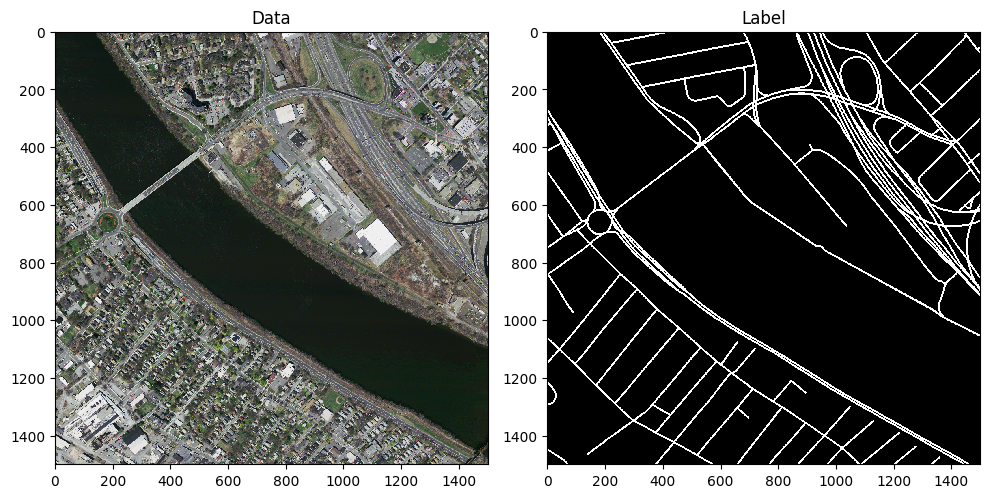

In [2]:
# Read the data
rgb = skio.imread("./data/massRoads/tiff/train/10828735_15.tiff")
ans = skio.imread("./data/massRoads/tiff/train_labels/10828735_15.tif")

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Label")


In [3]:
DATA_DIR = './data/massRoads/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("./data/massRoads/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [5]:
# image paths
image_paths = [os.path.join(x_train_dir, image_id) for image_id in sorted(os.listdir(x_train_dir))]
mask_paths = [os.path.join(y_train_dir, image_id) for image_id in sorted(os.listdir(y_train_dir))]

val_img_paths = [os.path.join(x_valid_dir, image_id) for image_id in sorted(os.listdir(x_valid_dir))]
val_mask_paths = [os.path.join(y_valid_dir, image_id) for image_id in sorted(os.listdir(y_valid_dir))]

test_img_paths = [os.path.join(x_test_dir, image_id) for image_id in sorted(os.listdir(x_test_dir))]
test_mask_paths = [os.path.join(y_test_dir, image_id) for image_id in sorted(os.listdir(y_test_dir))]


In [6]:
# prep image training
train_len = 50
patch_size = 128
num_patches = 1500 // patch_size  # Number of patches per dimension

small_train_images = []
small_train_labels = []

for i in range(train_len):
    # read images for each path
    training_image = cv2.imread(image_paths[i])
    training_mask = cv2.imread(mask_paths[i])

    for i in range(num_patches):
        for j in range(num_patches):
            # Extract patch from the image
            image_patch = training_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
            mask_patch = training_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
            
            if(len(np.unique(mask_patch))>1):

                #normalize
                image_patch = image_patch / 255
                mask_patch = mask_patch / 255

                small_train_images.append(image_patch)
                small_train_labels.append(mask_patch)

small_train_images = np.array(small_train_images)
small_train_labels = np.array(small_train_labels)[:,:,:,0]

In [7]:
small_train_images.shape

(3448, 128, 128, 3)

In [8]:
count = 0

for label in small_train_labels[:2000]:
    if(len(np.unique(label))==1):
       count += 1


print("Number of blank images: " + str(count))

Number of blank images: 0


In [9]:
val_len = len(val_img_paths)

val_img = [0] * val_len
val_masks = [0] * val_len

for i in range(val_len):
    val_img[i] = cv2.imread(val_img_paths[i])
    val_img[i] = val_img[i] / 255
    val_masks[i] = cv2.imread(val_mask_paths[i])
    val_masks[i] = val_masks[i] / 255

val_img = np.array(val_img[:])
val_img = val_img[:, :patch_size, :patch_size]
val_masks = np.array(val_masks)[:,:,:,0]
val_masks = val_masks[:, :patch_size, :patch_size]


In [31]:
count = 0

for label in val_masks:
    if(len(np.unique(label))==1):
       count += 1


print("Number of blank images: " + str(count))

Number of blank images: 1


In [10]:
test_len = len(test_img_paths)

test_img = [0] * test_len
test_masks = [0] * test_len

for i in range(test_len):
    test_img[i] = cv2.imread(test_img_paths[i])
    test_img[i] = test_img[i] / 255
    test_masks[i] = cv2.imread(test_mask_paths[i])
    test_masks[i] = test_masks[i] / 255

test_img = np.array(test_img[:])
test_img = test_img[:, :patch_size, :patch_size]
test_masks = np.array(test_masks)[:,:,:,0]
test_masks = test_masks[:, :patch_size, :patch_size]

In [32]:
count = 0

for label in test_masks:
    if(len(np.unique(label))==1):
       count += 1


print("Number of blank images: " + str(count))

Number of blank images: 19


In [11]:
print(small_train_images.shape)
print(small_train_labels.shape)
print(val_img.shape)
print(val_masks.shape)
print(test_img.shape)
print(test_masks.shape)

(3448, 128, 128, 3)
(3448, 128, 128)
(14, 128, 128, 3)
(14, 128, 128)
(49, 128, 128, 3)
(49, 128, 128)


Text(0.5, 1.0, 'Label')

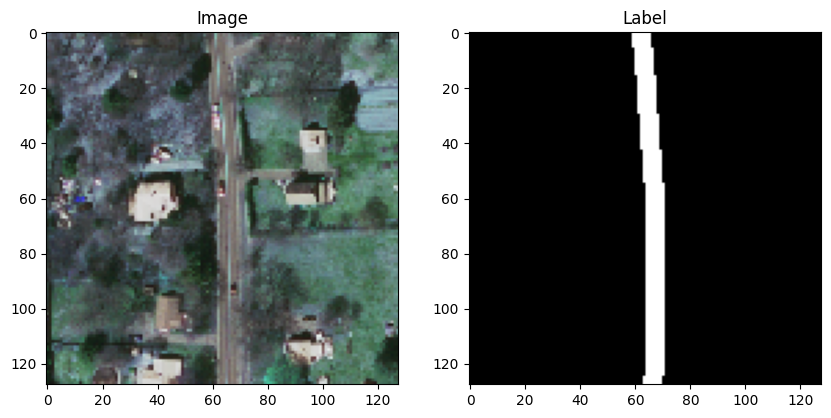

In [12]:
# Display training data and correct output
i = 500
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].imshow(small_train_images[i], cmap='gray')
ax[0].set_title("Image")
ax[1].imshow(small_train_labels[i], cmap='gray')
ax[1].set_title("Label")

In [13]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [14]:
# I found this architecture with the shape (128, 128, 1).

def unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(16,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    
    return model

In [15]:
model = unet()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 256) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ dropout_1[0][0] 

 Total params: 1,941,381 (7.41 MB)

 Trainable params: 1,941,381 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

Train with first 750 images

In [82]:
callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('unet_model.h5', save_best_only=True, verbose=2),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor= 'val_dice_coef', mode='max', restore_best_weights=True)
]

# Train the model
history = model.fit(x=small_train_images[:750], y=small_train_labels[:750], 
                    validation_data = (val_img, val_masks), epochs = 20, callbacks=[callbacks], 
                    verbose = 1)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - dice_coef: 0.4494 - loss: 0.1150 - val_dice_coef: 0.4529 - val_loss: 0.1392
Epoch 2/20
 3/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - dice_coef: 0.5123 - loss: 0.0988

KeyboardInterrupt: 

In [17]:
prediction = model.predict(test_img)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step


Text(0.5, 1.0, 'Image')

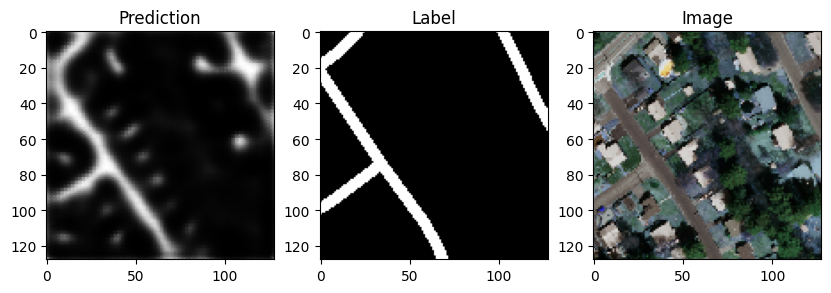

In [27]:
# Display training data and correct output
i = 20
fig, ax = plt.subplots(1, 3, figsize = (10, 6))
ax[0].imshow(prediction[i], cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(test_masks[i], cmap='gray')
ax[1].set_title("Label")
ax[2].imshow(test_img[i], cmap='gray')
ax[2].set_title("Image")

Train the model again wiht images 750-1500

In [19]:
# Train the model
history = model.fit(x=small_train_images[750:1500], y=small_train_labels[750:1500], 
                    validation_data = (val_img, val_masks), epochs = 20, callbacks=[callbacks], 
                    verbose = 1)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - dice_coef: 0.2316 - loss: 0.1549 - val_dice_coef: 0.2238 - val_loss: 0.2140
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - dice_coef: 0.2553 - loss: 0.1472 - val_dice_coef: 0.2162 - val_loss: 0.2248
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - dice_coef: 0.3001 - loss: 0.1399 - val_dice_coef: 0.2092 - val_loss: 0.2282
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - dice_coef: 0.3319 - loss: 0.1331 - val_dice_coef: 0.2704 - val_loss: 0.2174
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - dice_coef: 0.3906 - loss: 0.1293 - val_dice_coef: 0.3306 - val_loss: 0.2072
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - dice_coef: 0.4741 - loss: 0.1135 - val_dice_coef: 0.3308 - val_loss: 0.2239
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - dice_coef: 0.4950 - loss: 0.1127 - val_dice_coef: 0.3040 - val_loss: 0.1911
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - dice_coef: 0.5130 - loss: 0.1014 - val_dice_coef: 0.

In [20]:
prediction_2 = model.predict(test_img)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Text(0.5, 1.0, 'Image')

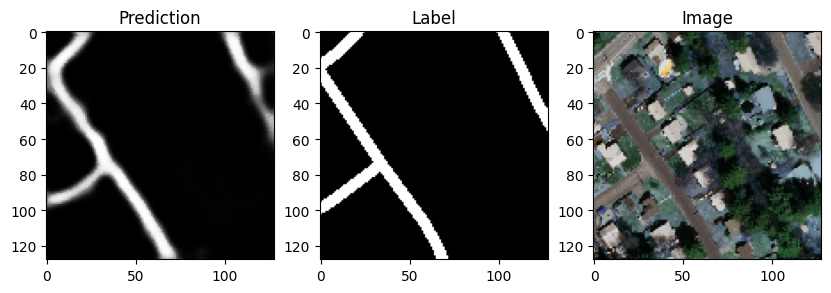

In [28]:
# Display training data and correct output
i = 20
fig, ax = plt.subplots(1, 3, figsize = (10, 6))
ax[0].imshow(prediction_2[i], cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(test_masks[i], cmap='gray')
ax[1].set_title("Label")
ax[2].imshow(test_img[i], cmap='gray')
ax[2].set_title("Image")

Train the model on training images 1500-2250

In [22]:
# Train the model
history = model.fit(x=small_train_images[1500:2250], y=small_train_labels[1500:2250], 
                    validation_data = (val_img, val_masks), epochs = 20, callbacks=[callbacks], 
                    verbose = 1)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - dice_coef: 0.5745 - loss: 0.1068 - val_dice_coef: 0.4897 - val_loss: 0.1779
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - dice_coef: 0.6172 - loss: 0.0948 - val_dice_coef: 0.5241 - val_loss: 0.1367
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.6208 - loss: 0.0882 - val_dice_coef: 0.5413 - val_loss: 0.1394
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.6338 - loss: 0.0875 - val_dice_coef: 0.5516 - val_loss: 0.1368
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.6411 - loss: 0.0853 - val_dice_coef: 0.5266 - val_loss: 0.1661
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.6694 - loss: 0.0782 - val_dice_coef: 0.5727 - val_loss: 0.1696
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.6900 - loss: 0.0746 - val_dice_coef: 0.5259 - val_loss: 0.1468


In [23]:
prediction_3 = model.predict(test_img)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


Text(0.5, 1.0, 'Image')

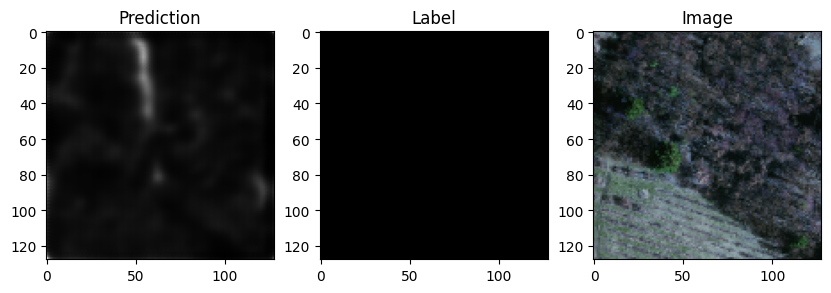

In [30]:
# Display training data and correct output
i = 40
fig, ax = plt.subplots(1, 3, figsize = (10, 6))
ax[0].imshow(prediction_3[i], cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(test_masks[i], cmap='gray')
ax[1].set_title("Label")
ax[2].imshow(test_img[i], cmap='gray')
ax[2].set_title("Image")

## Predicting our test image

In [33]:
image_filepath = "./data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels
testing_image = skio.imread(image_filepath + "/train/10828735_15.tiff")
testing_image_label = skio.imread(image_filepath + "/train_labels/10828735_15.tif")

In [34]:
small_test_images = []

for i in range(num_patches):
    for j in range(num_patches):
        # Extract patch from the image
        patch = testing_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        small_test_images.append(patch)

small_test_images = np.array(small_test_images)

In [64]:
test_prediction = model.predict(small_test_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step


### Reconstruct the image

In [133]:
def reconstruct_image(image_batches, num_patches, patch_size):
    #  Calculate the dimensions of the original image
    
    image_dim = num_patches * patch_size

    # Reshape the array
    reshaped_patches = np.reshape(image_batches, (num_patches, num_patches, patch_size, patch_size))

    # Initialize an empty array to store the reconstructed image
    reconstructed_image = np.zeros((image_dim, image_dim), dtype=np.uint8)

    # Reconstruct the image
    for i in range(num_patches):
        for j in range(num_patches):
            # Get the current patch
            patch = reshaped_patches[i][j]
            patch = patch > 0.5
            
            # Calculate the starting and ending indices for placing the patch
            start_i, start_j = i * patch_size, j * patch_size
            end_i, end_j = start_i + patch_size, start_j + patch_size
            
            # Place the patch in the reconstructed image
            reconstructed_image[start_i:end_i, start_j:end_j] = patch
    
    return reconstructed_image

In [134]:
reconstructed_image = reconstruct_image(test_prediction, num_patches=num_patches, patch_size=patch_size)

In [124]:
testing_image_label_shrunk = testing_image_label[:reconstructed_image.shape[0], :reconstructed_image.shape[1]]
testing_image_shrunk = testing_image[:reconstructed_image.shape[0], :reconstructed_image.shape[1]]

Text(0.5, 1.0, 'Image')

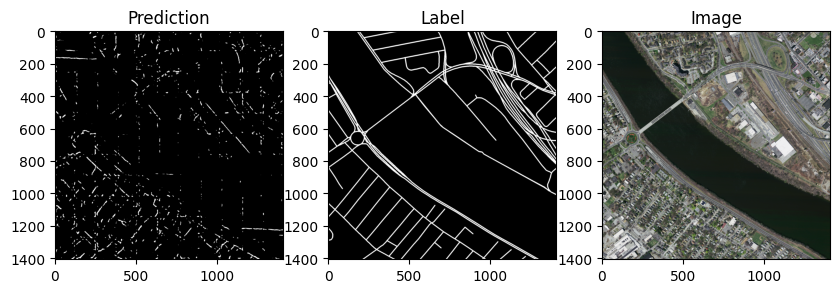

In [132]:
# Display training data and correct output
fig, ax = plt.subplots(1, 3, figsize = (10, 6))
ax[0].imshow(reconstructed_image, cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(testing_image_label_shrunk, cmap='gray')
ax[1].set_title("Label")
ax[2].imshow(testing_image_shrunk, cmap='gray')
ax[2].set_title("Image")

plt.show()

In [141]:
accuracy_metrics(reconstructed_image, testing_image_label_shrunk)

Confusion matrix:
 [[  10955   44651]
 [ 171527 1755331]]
Overall accuracy: 0.891 
Precision: 0.06 
Recall 0.197 
Dice Coefficient 0.092
